# Command


## O que é?

O padrao utiliza um objeto para encapsular uma requisicao a ser executada, promovendo assim o _decoupling_ entre o objeto que invoca uma acao e o objeto responsável por executá-la.

## Por quê?

O livro _Design Patterns_ menciona os seguintes contextos em que o padrao _Command_ pode ser útil: 

- Atrelar um comando a uma acao invocada em outro objeto -- por exemplo, um clique num menu
- Permitir que requisicoes sejam armazenadas e executadas em outro momento ou contexto
- Permitir a operacao _undo_ -- nesse caso, o _Command_ pode ser usado em conjunto com o _Memento_
- Manter um histórico das operacoes realizadas num sistema (e possivelmente re-executarlas)
- Contruir um sistema com base em transacoes que possuem a mesma interface

## Estrutura

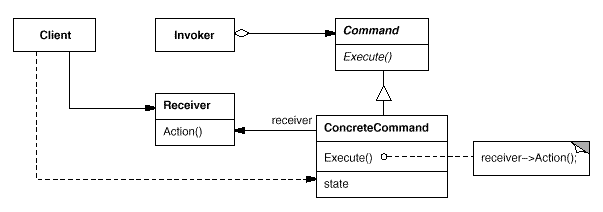


## Exemplo 1: Decoupling

Imaginemos um processador de texto simples, com apenas duas funcoes: adicionar conteúdo a um documento e salvá-lo. 
Para salvar o documento, o usuário deve clicar em um botao. Uma implementacao ingênua, sem o uso de patterns, seria mais ou menos assim:

In [4]:
class Document:
    def __init__(self, content: str = ""):
        self.content = content
    
    def write(self, text: str):
        self.content += text
        
    def save(self):
        file = open(f"document.txt", "w")
        file.write(self.content)
        file.close()

        
class SaveButton:
    def __init__(self, document: Document):
        self.document = document
        self.label = 'save'
    
    def click(self):
        document.save()
        

document = Document()
save_button = SaveButton(document)
document.write('Some random text')
save_button.click()

Um dos problemas dessa abordagem, porém, é que ela exige que o botao tenha o documento como dependência. Mais do que isso: todos os botoes precisariam de um método `click` diferente, sempre executando um ou mais métodos do documento. Em comparacao, o padrao `Command` retiraria essa responsabilidade da classe `Button`:

In [12]:
import abc


class Document:
    
    def __init__(self, content: str = ""):
        self.content = content
    
    def write(self, text: str):
        self.content += text
        
    def save(self):
        file = open(f"document.txt", "w")
        file.write(self.content)
        file.close()
    
    
class Command(abc.ABC):
    
    def __init__(self, document: Document):
        self.document = document
    
    @abc.abstractmethod
    def execute(self):
        pass

    
class SaveCommand(Command):
    
    def execute(self):
        self.document.save()
        
        
class Button(abc.ABC):
    def __init__(self, label: str, command: Command):
        self.label = label
        self.command = command
        
    def click(self):
        self.command.execute()
        

class SaveButton(Button):
    def __init__(self, command: SaveCommand):
        super().__init__('save', command)
        


document = Document()
save_command = SaveCommand(document)
save_button = SaveButton(save_command)
document.write('Some other random bit of text')
save_button.click()

Ao separar o objeto que invoca a acao (`Button`) do objeto responsável por executá-la (`Document`), o padrao `Command` permite que a classe `Button` seja mais enxuta e tenha menos responsabilidades. E caso desejemos disponibilizar ao usuário outra maneira de salvar o documento (com um atalho de teclado, por exemplo), podemos reaproveitar o comando.

## Exemplo 2: Transacoes e macro-commands

Imaginemos uma base de dados simples que permite ao usuário agregar tabelas ao schema e atualizá-las:

In [15]:
class Database:
    
    def __init__(self):
        self.schema = {}
    
    def create_table(self, table_name: str, fields: dict):
        self.schema[table_name] = {name: field_type for name, field_type in fields.items()}
        
    def alter_table(self, table_name: str, field: dict):
        for name, field_type in field.items():
            self.schema[table_name][name] = field_type
    
    def __str__(self):
        result = ""
        for table in self.schema:
            result += f"{table}\n"
            for field, field_type in self.schema[table].items():
                 result += f"\t{field} : {field_type}\n"
        return result

                    
                    
db = Database()
db.create_table("users", {"name":"var_char(256)", "age":"int(2)","gender":"var_char(1)"})
db.alter_table("users", {"age": "int(3)"})
print(db)        

users
	name : var_char(256)
	age : int(3)
	gender : var_char(1)



Cada execucao de `create_table` e `update_table` gera uma mudanca no schema da base de dados. Com o padrao Command, poderíamos isolar essa transacao e executá-la em mais de uma base de dados (diferentes ambientes de desenvolvimento, por exemplo).

In [28]:
class Database:
    
    def __init__(self):
        self.schema = {}
    
    def create_table(self, table_name: str, fields: dict):
        self.schema[table_name] = {name: field_type for name, field_type in fields.items()}
        
    def alter_table(self, table_name: str, field: dict):
        for name, field_type in field.items():
            self.schema[table_name][name] = field_type
    
    def __str__(self):
        result = ""
        for table in self.schema:
            result += f"{table}\n"
            for field, field_type in self.schema[table].items():
                 result += f"\t{field} : {field_type}\n"
        return result
    
    
    
class Migration:
    
    def __init__(self, db: Database, table_name: str, fields: dict):
        self.db = db
        self.table_name = table_name
        self.fields = fields
        
    def set_db(self, db: Database):
        self.db = db
    
    def execute(self):
        if self.table_name not in self.db.schema:
            self.db.create_table(self.table_name, self.fields)
        else: 
            self.db.alter_table(self.table_name, self.fields)
        
    

class TransactionHistory:
    
    def __init__(self):
        self.history = []
    
    def create_migration(self, db: Database, table_name: str, fields: dict) -> Migration:
        migration = Migration(db, table_name, fields)
        self.history.append(migration)
        return migration
    
    def execute_all(self,db: Database):
        for migration in self.history:
            migration.set_db(db)
            migration.execute()
                
                    
db = Database()
transactions = TransactionHistory()

migration1 = transactions.create_migration(db,"users", {"name":"var_char(256)", "age":"int(2)","gender":"var_char(1)"})
migration2 = transactions.create_migration(db, "users", {"age": "int(3)"})
migration1.execute()
migration2.execute()

print(db)        

del db


db = Database()
transactions.execute_all(db)

print(db)        

users
	name : var_char(256)
	age : int(3)
	gender : var_char(1)

users
	name : var_char(256)
	age : int(3)
	gender : var_char(1)



O método `execute_all` acima é um exemplo do que o livro chama de MacroCommand: uma classe responsável por executar uma sequência de comandos.

## Prós e contras:

### Pros:
- Promove o decoupling
- Possibilita a criacao de um histórico de transacoes
- Facilita operacoes de undo

### Cons:
- Aumenta a complexidade do sistema
- Pode provocar uma explosao no número de objetos Command


## Discussao: 

In the Motivation section of the Command pattern, an application's menu system is described. An application has a Menu, which in turn has MenuItems, which in turn execute commands when they are clicked. What happens if the command needs some information about the application in order to do its job? How would the command have access to such information such that new comamnds could easily be written that would also have access to the information they need?